# Regression using neural network models

Estimate (i.e. make regression for) the energy of electrons. This should be based on maximum 15 variables from the Electron Variable List. The target variable for this task is "p_truth_E": Energy (in GeV) of the electrons, and you should only train on real (i.e. truth identified, "Truth==1") electrons. Note: It is an advantage to ONLY train the regression on true electrons (Truth = 1), but when submitting the solution, the regression estimate should be applied to ALL candidates, as you don't (perfectly) know, which are electrons, and which are not. We evaluate algorithm performance by considering Mean Absolute Error (MAE) on relative estimate accuracy: (E_pred-E_true)/E_true.

We start by opening the files and loading them into a Numpy array

In [23]:
import h5py
import pandas
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [24]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        return pandas.DataFrame(f[name][:])

train = load_data('train')
test  = load_data('test')

In [25]:
## temporarily use a fraction of the data to speed everything up
#train=train.sample(frac = 0.3)

Then we can verify the shape

In [26]:
print (f'Shape of training data set: {train.shape}')
print (f'Shape of test data set: {test.shape}')

Shape of training data set: (162500, 166)
Shape of test data set: (160651, 164)


As expected, the test set contains 2 columns less: `Truth` and `p_truth_E`.
    
Then we copy the variable list from the course website <https://www.nbi.dk/~petersen/Teaching/ML2020/SmallProject/VariableList.html>

In [27]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

Finally, we divide the training data into data (`X`) and targets (`y`)

Only use the entries which we know are true electrons for training.


In [50]:
train = train.loc[train['Truth']==1]
X = train[all_variables]
y = train['p_truth_E']
X_test = test[all_variables]



print (f'Shape of X: {X.shape}')
print (f'Shape of y: {y.shape}')
print (f'Shape of X_test: {X_test.shape}')

Shape of X: (121495, 160)
Shape of y: (121495,)
Shape of X_test: (160651, 160)


In [29]:
X.head(2)

,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,p_pt_track,p_eta,...,p_E5x7_Lr0,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1
0,26.5,26.5,26.5,26.5,26.5,26.5,18,3,42011.792969,1.834715,...,215.588013,43402.332031,74045.820312,337.980713,273.708801,43091.683594,74447.539062,470.177124,273.708801,43091.683594
3,37.5,37.5,37.5,37.5,37.5,37.5,17,2,44975.042969,-2.023659,...,0.000000,27372.955078,104002.000000,921.178040,0.000000,27101.673828,106995.789062,1127.115356,0.000000,27101.673828


In [30]:
#!pip install seaborn update

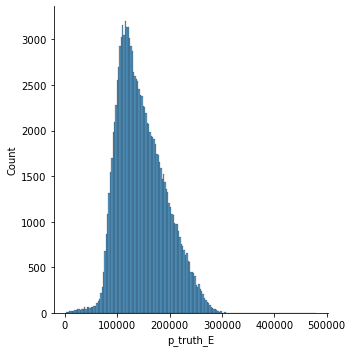

In [31]:
sns.displot(data=train, x=y)

## Preprocessing

### Check null values

In [32]:
train.isnull().sum()

eventNumber                       0
runNumber                         0
actualInteractionsPerCrossing     0
averageInteractionsPerCrossing    0
correctedActualMu                 0
                                 ..
p_E7x11_Lr2                       0
p_E7x11_Lr3                       0
p_E7x7_Lr0                        0
p_E7x7_Lr1                        0
index                             0
Length: 166, dtype: int64

No nulls
### Scale the data

In [51]:
transformed_X = deepcopy(X) 
transformed_X_test = deepcopy(X_test)
# This loop transforms every variable _independently_ 
for variable in X.columns: 
    scaler = RobustScaler().fit(np.array(transformed_X[variable]).reshape(-1,1))
    transformed_X[variable] = scaler.transform(np.array(transformed_X[variable]).reshape(-1,1))
    transformed_X_test[variable] = scaler.transform(np.array(transformed_X_test[variable]).reshape(-1,1))

### Select k Best features

In [34]:
from sklearn.feature_selection import SelectKBest, f_regression

In [54]:
# Create and fit selector
selector = SelectKBest(score_func=f_regression, k=15)
X_15 = selector.fit_transform(transformed_X, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
features_df_new.columns

/Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Index(['p_eCluster', 'p_rawECluster', 'p_eClusterLr2', 'p_eAccCluster',
       'p_cellIndexCluster', 'p_E7x7_Lr2', 'p_e235', 'p_e255', 'p_ecore',
       'p_e233', 'p_e237', 'p_e277', 'p_E3x5_Lr2', 'p_E5x7_Lr2',
       'p_E7x11_Lr2'],
      dtype='object')

In [56]:
transformed_X_test_15 = selector.transform(transformed_X_test)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_15,y,test_size=.3, random_state=42)

In [37]:
from sklearn.metrics import mean_absolute_error

# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))


Baseline MAE is 36932.90


## XGBoost regression

In [20]:
# # xgboost for regression
# from xgboost import XGBRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# # evaluate the model
# model = XGBRegressor(objective='reg:squarederror')
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_15, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
# # fit the model on the whole dataset
# model = XGBRegressor(objective='reg:squarederror')
# model.fit(X, y)


## LightGBM regression

In [21]:
# from lightgbm import LGBMRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold

# # evaluate the model
# model = LGBMRegressor()
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_15, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
# # fit the model on the whole dataset
# model = LGBMRegressor()
# model.fit(X, y)


## Hyperparameter tuning

### Random Search

In [18]:
# from scipy.stats import loguniform
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import RepeatedKFold
# from sklearn.model_selection import RandomizedSearchCV

# # define model
# model = Ridge()
# # define evaluation
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define search space
# space = dict()
# space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
# space['alpha'] = loguniform(1e-5, 100)
# space['fit_intercept'] = [True, False]
# space['normalize'] = [True, False]
# # define search
# search = RandomizedSearchCV(model, space, n_iter=500, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1, verbose=1)
# # execute search
# result = search.fit(X_15, y)
# # summarize result
# print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 500 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 12784 tasks      |

Best Score: -6462.42947586077
Best Hyperparameters: {'alpha': 0.0002531181460133387, 'fit_intercept': True, 'normalize': True, 'solver': 'svd'}


[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed: 57.1min finished


### Grid Search

In [16]:
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import RepeatedKFold
# from sklearn.model_selection import GridSearchCV

# # define model
# model = Ridge()
# # define evaluation
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define search space
# space = dict()
# space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
# space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# space['fit_intercept'] = [True, False]
# space['normalize'] = [True, False]
# # define search
# search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, verbose=1)
# # execute search
# result = search.fit(X_15, y)
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 128 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed: 14.4min finished


Best Score: -6464.314837511495
Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [ ]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import RepeatedKFold
# from sklearn.model_selection import GridSearchCV

# # define model
# model = XGBRegressor()
# # define evaluation
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define search space
# parameters = {
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}
# # define search
# search = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, verbose=1)
# # execute search
# result = search.fit(X_15, y)
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 9 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 23.6min


## Bayesian optimisation of hyperparameters and cross validation

In [69]:
from sklearn.neural_network import MLPRegressor


In [70]:
def sklNN_CrossValidation(hidden_layer_sizes, learning_rate_init, data, targets):
    """Cross validation.
       Fits a NN with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations
       that maximize the accuracy
    """
    
    estimator = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init, random_state=0)
    
    cval = cross_val_score(estimator, data, targets, scoring='neg_mean_absolute_error', cv=5)
    
    return cval.mean()

In [71]:
def optimize_sklNN(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to NN parameters."""
    
    def crossval_wrapper(hidden_layer_sizes, learning_rate_init):
        """Wrapper of NNe cross validation. 
           hidden_layer_sizes
           is cast to integer before we pass them along.
        """
        return sklNN_CrossValidation(hidden_layer_sizes=int(hidden_layer_sizes), 
                                            learning_rate_init=learning_rate_init, 
                                            data=data, 
                                            targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=100)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [25]:
parameters_BayesianOptimization = {"hidden_layer_sizes": (1, 100), 
                                   "learning_rate_init": (0.0001, 1)
                                  }

BayesianOptimization = optimize_sklNN(X_15, 
                                             y, 
                                             parameters_BayesianOptimization, 
                                             n_iter=5)
print(BayesianOptimization.max)

|   iter    |  target   | hidden... | learni... |
-------------------------------------------------
|  1        | -6.947e+0 |  38.08    |  0.9507   |
|  2        | -6.409e+0 |  73.47    |  0.5987   |
|  3        | -6.515e+0 |  16.45    |  0.1561   |
|  4        | -6.461e+0 |  6.75     |  0.8662   |
|  5        | -6.531e+0 |  73.55    |  0.5979   |
|  6        | -6.531e+0 |  73.47    |  0.598    |
|  7        | -6.46e+03 |  6.747    |  0.8607   |
|  8        | -6.462e+0 |  30.77    |  0.4783   |
|  9        | -6.388e+0 |  73.47    |  0.5976   |
{'target': -6387.571888318518, 'params': {'hidden_layer_sizes': 73.46755675774493, 'learning_rate_init': 0.5975716395036551}}


Cross-validation on result:



In [30]:
reg = MLPRegressor(hidden_layer_sizes=int(BayesianOptimization.max['params']['hidden_layer_sizes']), 
                                 learning_rate_init=BayesianOptimization.max['params']['learning_rate_init'],
                                 random_state=0)
scores = cross_val_score(reg, X_15, y, cv=5, scoring='neg_mean_absolute_error') 
print(f"{scores.mean():.4f} MAE with a standard deviation of {scores.std():.4f}")

-6387.5719 MAE with a standard deviation of 121.9844


In [72]:
parameters_BayesianOptimization = {"hidden_layer_sizes": (60, 90), 
                                   "learning_rate_init": (0.3, 0.6)
                                  }

BayesianOptimization = optimize_sklNN(X_15, 
                                             y, 
                                             parameters_BayesianOptimization, 
                                             n_iter=5)
print(BayesianOptimization.max)

|   iter    |  target   | hidden... | learni... |
-------------------------------------------------
|  1        | -6.43e+03 |  71.24    |  0.5852   |
|  2        | -6.971e+0 |  81.96    |  0.4796   |
|  3        | -6.516e+0 |  64.68    |  0.3468   |
|  4        | -6.72e+03 |  61.74    |  0.5599   |
|  5        | -6.366e+0 |  71.31    |  0.5687   |
|  6        | -6.683e+0 |  71.69    |  0.476    |
|  7        | -6.408e+0 |  71.3     |  0.3316   |
|  8        | -6.519e+0 |  64.2     |  0.4316   |
|  9        | -6.689e+0 |  70.88    |  0.3125   |
{'target': -6366.182935977597, 'params': {'hidden_layer_sizes': 71.30506683048498, 'learning_rate_init': 0.5687396572526524}}


In [73]:
reg = MLPRegressor(hidden_layer_sizes=int(BayesianOptimization.max['params']['hidden_layer_sizes']), 
                                 learning_rate_init=BayesianOptimization.max['params']['learning_rate_init'],
                                 random_state=0)
scores = cross_val_score(reg, X_15, y, cv=5, scoring='neg_mean_absolute_error') 
print(f"{scores.mean():.4f} MAE with a standard deviation of {scores.std():.4f}")

-6366.1829 MAE with a standard deviation of 87.2863


In [74]:
reg.fit(X_15, y)

MLPRegressor(hidden_layer_sizes=71, learning_rate_init=0.5687396572526524,
             random_state=0)

## Run algo on test data and make output files

In [77]:
mlpreg_predictions = reg.predict(transformed_X_test_15)

In [79]:
out_df_mlp=pandas.DataFrame(mlpreg_predictions)

In [80]:
out_df_mlp.to_csv('solutions/Regression_NiallGray_MLPReg.txt',header=False)

In [81]:
feature_list.to_csv('solutions/Regression_NiallGray_MLPReg_VariableList.txt',index=False, header=False)

### Autokeras

In [40]:
# use autokeras to find a model for the insurance dataset
from sklearn.model_selection import train_test_split
from autokeras import StructuredDataRegressor
from numpy import asarray


In [39]:
# define the search
search = StructuredDataRegressor(max_trials=15, loss='mean_absolute_error')
# perform the search
search.fit(x=X_train, y=y_train, verbose=0)
# evaluate the model
mae, _ = search.evaluate(X_test, y_test, verbose=0)
print('MAE: %.3f' % mae)


INFO:tensorflow:Reloading Oracle from existing project ./structured_data_regressor/oracle.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/231
2658/2658 [==============================] - 6s 2ms/step - loss: 126748.5057 - mean_squared_error: 18768837845.7345A: 1s - loss: 138591.4469 - mean - ETA: 0s - loss: 128936.2093 - mean_squared_error: 19244439194 - ETA: 0s - loss: 127363.1123 - mean_squared_error: 18902033672.8
Epoch 2/231
2658/2658 [==============================] - 5s 2ms/step - loss: 61933.1744 - mean_squared_error: 5375609508.4408
Epoch 3/231
2658/2658 [==============================] - 5s 2ms/step - loss: 50551.6240 - mean_squared_error: 3592719610.8973A: 3s - loss: 54322.2942 - mean_squar - ETA: 1s - loss: 53152.2777
Epoch 4/231
2658/2658 [==============================] - 5s 2ms/step - loss: 11611.7117 - mean_squared_error: 352658721.2877
Epoch 5/231
2658/2658 [==============================] - 5s 2ms/step - loss: 7773.9292 - mean_squared_error: 229255281.2576
Epoch 6/23

2658/2658 [==============================] - 6s 2ms/step - loss: 6173.8738 - mean_squared_error: 202360684.4859
Epoch 58/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6171.9457 - mean_squared_error: 202347022.1008A: 1s - loss: 6198.3643 - mean_squared_error: 2060160 - ETA: 1s - loss: 6192.2001 - mean_square
Epoch 59/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6171.0024 - mean_squared_error: 202349640.7311
Epoch 60/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6169.2971 - mean_squared_error: 202346015.9767
Epoch 61/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6167.9349 - mean_squared_error: 202347890.3919
Epoch 62/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6166.8820 - mean_squared_error: 202327449.5495
Epoch 63/231
2658/2658 [==============================] - 6s 2ms/step - loss: 6165.5517 - mean_squared_error: 202314165.9316A: 5s - loss: 6391.3960 - mea
Epoch 64/231
2

2658/2658 [==============================] - 5s 2ms/step - loss: 6133.9525 - mean_squared_error: 202398231.7225
Epoch 120/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6133.6736 - mean_squared_error: 202413662.4889
Epoch 121/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6133.5465 - mean_squared_error: 202410529.4968
Epoch 122/231
2658/2658 [==============================] - 6s 2ms/step - loss: 6133.0604 - mean_squared_error: 202406656.3174
Epoch 123/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6133.2244 - mean_squared_error: 202406059.2554
Epoch 124/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6132.2869 - mean_squared_error: 202415518.6807A: 2s - l
Epoch 125/231
2658/2658 [==============================] - 6s 2ms/step - loss: 6132.4893 - mean_squared_error: 202406529.5006
Epoch 126/231
2658/2658 [==============================] - 5s 2ms/step - loss: 6132.7498 - mean_squared_error: 202398939.37

2658/2658 [==============================] - 4s 2ms/step - loss: 6125.2377 - mean_squared_error: 202428591.3095
Epoch 181/231
2658/2658 [==============================] - 4s 2ms/step - loss: 6125.3091 - mean_squared_error: 202442705.3704
Epoch 182/231
2658/2658 [==============================] - 4s 2ms/step - loss: 6125.1179 - mean_squared_error: 202457033.6217
Epoch 183/231
2658/2658 [==============================] - 4s 2ms/step - loss: 6124.9139 - mean_squared_error: 202427993.6427
Epoch 184/231
2658/2658 [==============================] - 4s 2ms/step - loss: 6125.0222 - mean_squared_error: 202445901.5976
Epoch 185/231
2658/2658 [==============================] - 4s 2ms/step - loss: 6124.9425 - mean_squared_error: 202415490.4882
Epoch 186/231
2658/2658 [==============================] - 4s 2ms/step - loss: 6124.7421 - mean_squared_error: 202410346.0835
Epoch 187/231
2658/2658 [==============================] - 4s 2ms/step - loss: 6124.7548 - mean_squared_error: 202445414.9003
Epoch 

ValueError: in user code:

    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/autokeras/keras_layers.py:90 call  *
        split_inputs = tf.split(input_nodes, [1] * len(self.encoding), axis=-1)
    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2053 split
        return gen_array_ops.split_v(
    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py:10085 split_v
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: can't split axis of size 1 into pieces of size [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] for '{{node model/multi_category_encoding/split}} = SplitV[T=DT_FLOAT, Tlen=DT_INT32, num_split=15](model/Cast_1, model/multi_category_encoding/Const, model/multi_category_encoding/split/split_dim)' with input shapes: [?,1], [15], [] and with computed input tensors: input[1] = <1 1 1 1 1 1 1 1 1 1 1 1 1 1 1>, input[2] = <-1>.


In [44]:
# evaluate the model
mae, _ = search.evaluate(X_test, y_test, verbose=0)
print('MAE: %.3f' % mae)

MAE: 6133.658


In [49]:
# get the best performing model
model = search.export_model()
# summarize the loaded model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 15)                0         
_________________________________________________________________
normalization (Normalization (None, 15)                31        
_________________________________________________________________
dense (Dense)                (None, 32)                512       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

In [48]:
# save the best performing model to file
model.save('model_NNReg_Autokeras.tf', save_format='tf')

INFO:tensorflow:Assets written to: model_NNReg_Autokeras.tf/assets


## Run algo on test data and make output files

In [58]:
autokeras_predictions = model.predict(transformed_X_test_15)[:,0]

In [61]:
out_df_AK=pandas.DataFrame(autokeras_predictions)

In [62]:
out_df_AK.to_csv('solutions/Regression_NiallGray_AutoKeras.txt',header=False)

In [ ]:
#features_df_new.feature_name.to_csv('solutions/Regression_NiallGray_AutoKeras_VariableList.txt',index=False, header=False)

### Get the used feature list

In [66]:
feature_list=pandas.DataFrame(features_df_new.columns)

In [68]:
feature_list.to_csv('solutions/Regression_NiallGray_AutoKeras_VariableList.txt',index=False, header=False)